# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy.linalg import inv

# Download data

In this section we will download the data and setup the paths.


In [2]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [3]:
from scipy.interpolate import RectBivariateSpline

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    p = M.flatten()[:6]
    num_iters = int(num_iters)

     # ===== your code here! =====

    interpolated_It1 = RectBivariateSpline(
        x=np.arange(It1.shape[0]),
        y=np.arange(It1.shape[1]),
        z=It1
    )

    # Generate original coordinates
    x, y = np.meshgrid(np.arange(It.shape[1]), np.arange(It.shape[0]))
    X = x.flatten()
    Y = y.flatten()

    # Iterate
    for _ in range(num_iters):
        warp_X = p[0] * X + p[1] * Y + p[2]
        warp_Y = p[3] * X + p[4] * Y + p[5]

        # Boundary
        valid = (warp_X >= 0) & (warp_X < It1.shape[1]) & (warp_Y >= 0) & (warp_Y < It1.shape[0])
        warp_X = warp_X[valid]
        warp_Y = warp_Y[valid]
        X_valid = X[valid]
        Y_valid = Y[valid]

        # Compute Gradient
        Ix = interpolated_It1.ev(warp_Y, warp_X, dx=0, dy=1)
        Iy = interpolated_It1.ev(warp_Y, warp_X, dx=1, dy=0)

        # Jacobian
        Jacobian = np.vstack([Ix * X_valid, Ix * Y_valid, Ix, Iy * X_valid, Iy * Y_valid, Iy]).T

        # Error
        error = (It.flatten()[valid] - interpolated_It1.ev(warp_Y, warp_X)).flatten()

        # Hessian
        Hessian = Jacobian.T @ Jacobian

        dp = np.linalg.lstsq(Hessian, Jacobian.T @ error, rcond=None)[0]
        p += dp

        if np.linalg.norm(dp) < threshold:
            break

    M = np.vstack([p[:6].reshape(2, 3), [0, 0, 1]])[:2, :]
    # # ===== End of code =====
    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

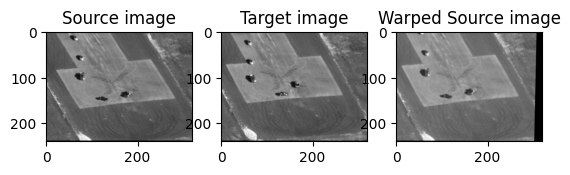

In [4]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("/content/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [5]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # # ===== your code here! =====
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    warp = affine_transform(It, M[:2, :2], offset=M[:2, 2], output_shape=It1.shape)
    diff_image = It1 - warp
    mask = np.abs(diff_image) > tolerance
    mask = binary_erosion(mask, structure=np.ones((2, 2)))
    mask = binary_dilation(mask, structure=np.ones((5, 5)))
    # ===== End of code =====

    return mask


## Q3.3: Tracking with affine motion (10 points)

In [6]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape
    masks = []
    It = seq[:,:,0]

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i - 1]
        It1 = seq[:, :, i]

        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [7]:
seq = np.load("/content/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.1

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [01:17<00:00,  1.60it/s]


Ant Sequence takes 77.798629 seconds


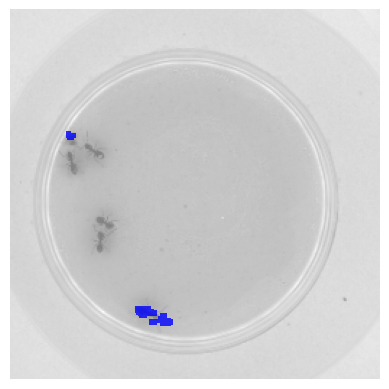

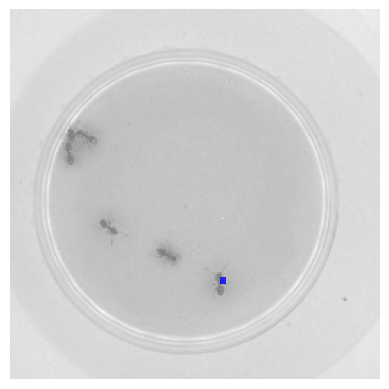

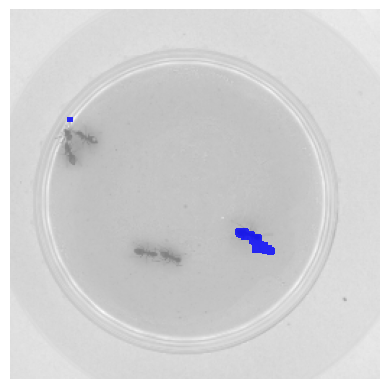

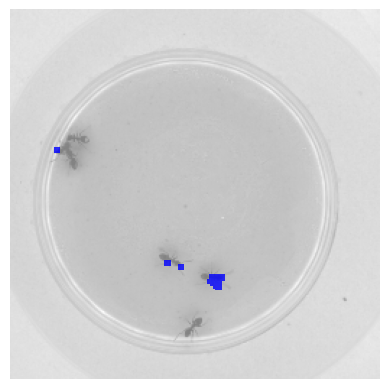

In [8]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [9]:
seq = np.load("/content/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.3

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [03:08<00:00,  1.27s/it]


Ant Sequence takes 188.786896 seconds


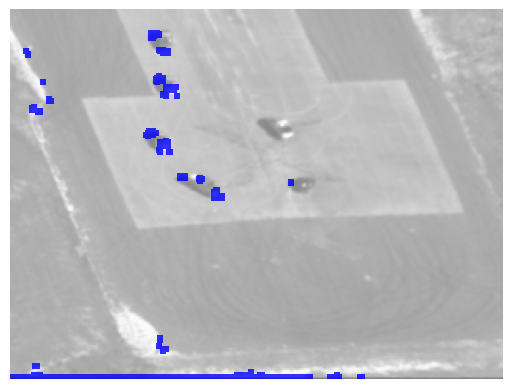

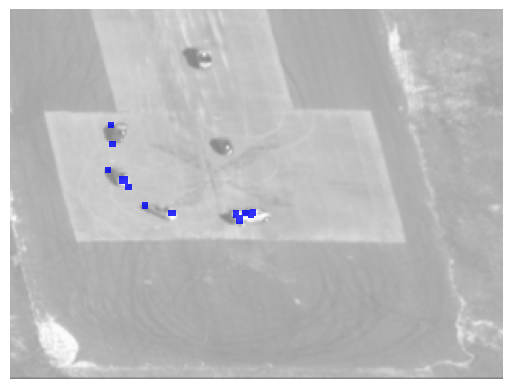

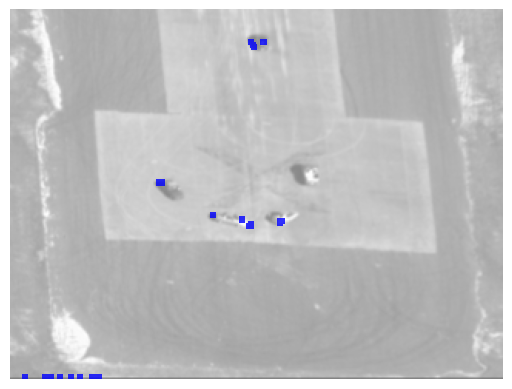

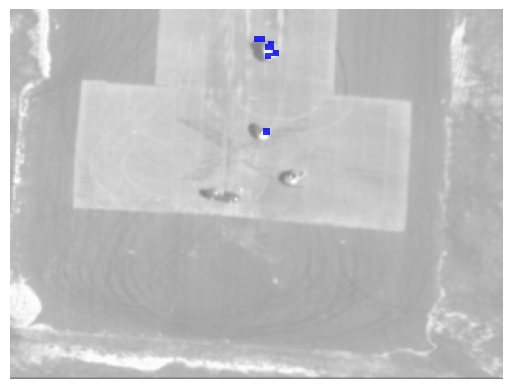

In [10]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')